<a href="https://colab.research.google.com/github/dsercam/mold-inspired/blob/main/Mold_Network_Entrega5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='darkorange'><b> Maestría en Inteligencia Artificial Aplicada </b> </font>
# <font color='darkblue'>Tecnológico de Monterrey</font>

## **Bio-Inspired ML Solutions for Sustainable Urban Development**
## **Mold Slime Inspired Network Modeling**
### **<font color='darkblue'>Model Baseline + Use of elevation map for restricted areas</font>**

### _Advisors_:
- Carlos Alberto Villaseñor Padilla
- Andrés Felipe Téllez Crespo

### _Contributors_:
- Dante Rodrigo Serna Camarillo
- Jorge Luis Pedroza Rivera
- Axel Alejandro Tlatoa Villavicencio


# <font color='darkorange'> Context </font>

- This collab file contains a second POC of a model inspired by the mold slime growth behavior. This notebook covers a basic implementation of the equation described at the paper Rules for [Biologically Inspired Adaptive Network Design (2010)](https://www.researchgate.net/publication/41111573_Rules_for_Biologically_Inspired_Adaptive_Network_Design).
As part of this incremental POC, the code has now been updated to work with an elevation map, which also help us determine a _restricted area_ for the mold growth.

- Most papers and research being used as references for this idea are related to the *Physarum polycephalum* a type of slime mold, being an unicellular, multi-nucleated organism. This _Amoeba-like_ organism develops as a massive cell body with an extended network of veins that carry protoplasmic fluid to distribute nutrients and other matter throughout its body. One of the most interesting attributes of the *Physarum polycephalum* is that it reacts to changing environmental conditions by adapting the topology (veins) of its network. It also lacks a central nervous system, through multiple researches, it is believed that its restructuring/adapting property is the result of some local optimization processes.

## <font color='darkblue'> Necessary imports and installs</font>

In [76]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from shapely.geometry import LineString, Polygon, Point
from IPython.display import HTML
import matplotlib.animation as animation
%matplotlib inline

In [77]:
!apt install gdal-bin
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
GDAL 3.6.4, released 2023/04/17


- The GDAL library will be used to handle eleveation map images, it has exisitng methods that should be useful to handle this type of data.

- We will be using a section of an elevation map belonging to the mexican state of Hidalgo

In [103]:
#GDAL to handle elevation maps.
from osgeo import gdal
elevation_map = gdal.Open('Hidalgo_r15m.tif').ReadAsArray()
print('Elevation map size: ', elevation_map.shape) #map size in pixels

Elevation map size:  (12965, 13497)


## <font color='darkblue'> Defining a plane/grid </font>
- Defining the size of the grid/plane to use.
- Intuitively, the grid size might impact the accuracy of the representation of out points of interest, based on maps and other input data. However this might become irrelevant when working with real maps or will probably need some _trasnformation_ between a given system of reference and a geogrpahical system or reference.

- We set the *elevation_map* object as a section of the Hidalgo elevation map, which is quite larege at 12965x13497 px

In [104]:
# Map has a signifcant size, lets get a section of it for demo purposes
elevation_map =  elevation_map[3160:5300,4000:8600]
workspace_latitude = elevation_map.shape[0] # Dimensions of the map section to be used
workspace_longitude = elevation_map.shape[1]

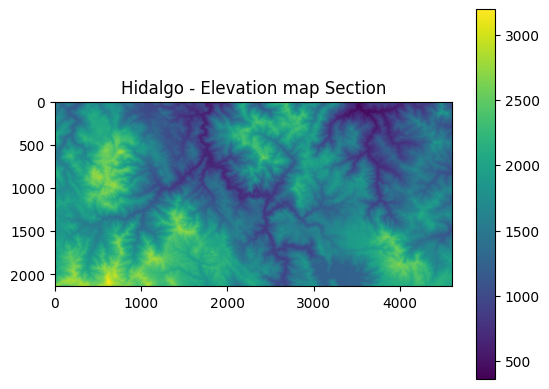

In [105]:
#Render map to validate section
plt.figure()
plt.imshow(elevation_map) # render our elevation map
plt.title('Hidalgo - Elevation map Section')
plt.colorbar()
plt.show()
#Blue areas - lower elevation
#Yellow areas - higher elevation

## <font color='darkblue'> Defining obstacles using the elevation map </font>
- The following code generates a boolen map from our elevation map/image to represent sections of "hard" obstacles, which should be avoided by the model during its growth.
- Strategy: Identifying the pixels of the image that fall within a min a max altitude, which would be valid for graph growth/development.
- The complement of the area represents regions with an altitude tha will be considered as restricted/obstacles.
</br>


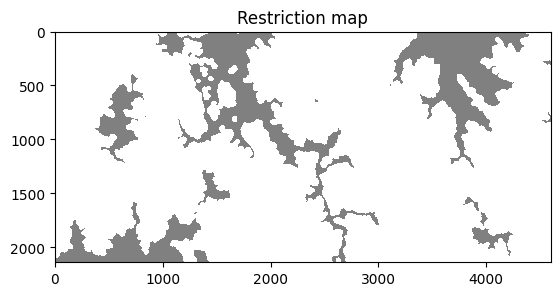

Final map size:  (2140, 4600)


In [106]:
# Libraries for image processing
from skimage.morphology import binary_dilation
from skimage import morphology
from skimage.filters import gaussian
import matplotlib.colors

# Define a color map for allowed and restricted areas.
# white will be used as allowed areas
# gray represents restricted areas
cmap_elevation_mask = matplotlib.colors.ListedColormap(['white', 'gray'])

# Define a "goldilocks zone" between 1200 and 2300 elevation
max_altitude = 2300
min_altitude = 1200

boolean_map = gaussian(elevation_map, sigma=10) #apply gaussian filter to our original elevation map
boolean_map = (elevation_map < max_altitude)&(elevation_map > min_altitude) # Get outline of terrain within our goldilocks zone
boolean_map = binary_dilation(boolean_map, morphology.disk(radius=10))
boolean_map = 1 - binary_dilation(boolean_map, morphology.disk(radius=10))

# Render restricted areas map
plt.figure()
plt.imshow(boolean_map, cmap=cmap_elevation_mask)
plt.title('Restriction map')
plt.show()

print('Final map size: ', boolean_map.shape)


## <font color='darkblue'> IDEA: define an elevation score using the derivative map </font>
- Use an image derivative to calculate the slope value of a given edge, which could be used as a boosting score or handicap between nodes.

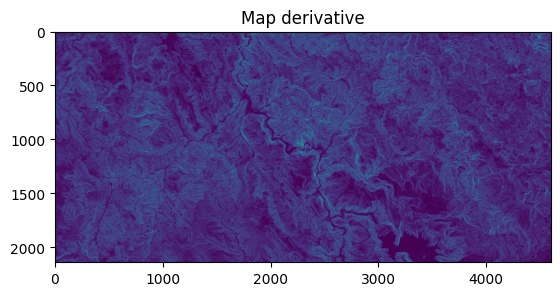

In [107]:
# Generate a map derivative
from skimage.filters import laplace
from skimage.filters import sobel
dev_map = sobel(elevation_map/np.sum(elevation_map)) #apply sobel filter to our section of the elevation map
dev_map = dev_map/(np.max(dev_map)-np.min(dev_map)) # generate the elevation map as dev_map

plt.figure()
plt.imshow(dev_map)
plt.title('Map derivative')
plt.show()

TODO: Refine a method that calcualtes a score for the elevation of an edge.

In [108]:
def score_elevation(dev_map, start, end):

  s = Point(start[0], start[1]) #staring endpoint of edge
  e = Point(end[0], end[1]) # ending enpoint of edge

  rr, cc = line(int(s.x), int(s.y), int(e.x), int(e.y))
  pixels = dev_map[rr, cc]
  return np.max(pixels)

## <font color='darkblue'> Supporting methods to validate collision with restricted areas.

In [109]:
#import
from skimage.draw import line

# Function contains(boolean_map, point)
# Given a binary map (boolean_map) - determine if a specified point falls within a restricted area.
def contains(boolean_map, point):
  return boolean_map[int(point.x), int(point.y)] #returns true if the point exists in the boolean map (gray area)

#Function line_collision(boolean_map, start, end)
# Function help us determine if an edge - defined as a line between two points, crosses a restricted area
def line_collision(boolean_map, start, end):

  s = Point(start[0], start[1]) #start point
  e = Point(end[0], end[1]) # end point

  # First determine if either the start or end points are in a restricted area, if any of them is, return TRUE immediately
  if contains(boolean_map, s) or contains(boolean_map, e): return True

  # if endpoints are clear, lets determine if any point in the edge between them falls into a restricted area
  rr, cc = line(int(s.x), int(s.y), int(e.x), int(e.y))
  pixels = boolean_map[rr, cc] # pixels in the line matching against pixels on the restricted areas - if any, return true
  if True in pixels:
    return True
  return False



In [110]:
# Function contains(boolean_map, point)
# Given a binary map - determine if a specified point falls within a restricted area.
def contains_point(boolean_map, point):
  return boolean_map[int(point[0]),int(point[1])] #returns true if the point exists in the boolean map (gray area)

#Function line_collision_points(boolean_map, start, end)
# Function help us determine if an edge - defined as a line between two points, crosses a restricted area
def line_collision_points(boolean_map, start_node, end_node, node_positions):

  s = node_positions[start_node] #start point
  e = node_positions[end_node] # end point

  # First determine if either the start or end points are in a restricted area, if any of them is, return TRUE immediately
  if contains_point(boolean_map, s) or contains_point(boolean_map, e): return True

  # if endpoints are clear, lets determine if any point in the edge between them falls into a restricted area
  rr, cc = line(int(s[0]),int(s[1]), int(e[0]),int(e[1]))
  pixels = boolean_map[rr, cc] # pixels in the line matching against pixels on the restricted areas - if any, return true
  if True in pixels:
    return True
  return False


## <font color='darkblue'> Building our base graph </font>
- A node is a point that must be connected by the resulting graph.
- In this example we are defining a set of nodes with random location within our map. Nodes are only located outside the restricted areas - in the goldilocks region.
- Note: when connecting each node to _n_ of its closest neighbours we are affecting the node degree, it appears that this impacts how the weights/conductivities converge. Further experimentaton needed to figure out an appropriate relation between number of nodes and the number of connected neighbours.


In [129]:
def generate_graph(node_qty, restriction_map, min_lat = 0, max_lat = 0, min_lon = 0, max_lon = 0):
    # Dictionary to hold node # and its position within the workspace
    node_positions = {}
    for node_index in range(node_qty):
        while True:
          x, y = np.random.uniform(min_lat, max_lat), np.random.uniform(min_lon, max_lon) #random point within our workspace dimesnions
          point = Point(x, y)
          # Validate the point does not fall into a restricted area
          #if cleared, assign coordinates to the point, a new set of values will be considered otherwise until condition is fulfilled
          if not (contains(restriction_map, point)):
              node_positions[node_index] = (x, y)
              break  # Exit assignment on valid position

    # Create empty graph.
    G = nx.Graph()
    # add our generated positions to the graph
    G.add_nodes_from(node_positions.keys())

    return G , node_positions

In [130]:
G, node_coordiantes = generate_graph(100, boolean_map, 0, workspace_latitude, 0, workspace_longitude)

In [132]:
def connect_k_closest_nodes(graph, node_positions, k, restriction_map):
  for node in graph.nodes():
    # Calculate distances to other nodes
    distances = []
    for second_node in graph.nodes():
        if second_node != node: #if we are not selecting the same node twice... calculate distance between nodes
            distance = np.hypot(node_positions[node][0] - node_positions[second_node][0],
                                 node_positions[node][1] - node_positions[second_node][1])
            distances.append((second_node, distance))
    # Order by distance and connect to closest nodes
    distances.sort(key=lambda x: x[1])
    neighbours = [n for n, d in distances[:k]]
    for neighbour in neighbours:
        # Generate an edge if the line between two given nodes does not cross a restricted area
        start = node_positions[node]
        end   = node_positions[neighbour]
        if not(line_collision(restriction_map, start, end)):
            if not graph.has_edge(node, neighbour):
                graph.add_edge(node, neighbour)


In [133]:
connect_k_closest_nodes(G, node_coordiantes, 5, boolean_map)

## <font color='darkblue'> Foundations for the mathematical model - Assigning pressures and conductivities</font>
- The proposed model describes the growth of the mold slime as a _Hagen-Poiseuille_ equation, where the flux can be described as:
</br></br>
$$
Q_{ij} = \frac{D_{ij}(p_i - p_j)}{L_{ij}}
$$
</br></br>
Two important concepets _conductivity_ and _longitude_ of a given edge are relevant for the calculation of an edge weight. Considering that, each edge is initialized with a conducitvity (1.0) by default and a lonngitude (in this calcualted as the distance between points).

In [135]:
def initialize_conductivity_longitude(graph,postions):
# Initialize conductivity and longitude for each graph edge.
  D = {}
  L = {}
  for edge in graph.edges():
    # Initial conductivity as 1
    D[edge] = 1.0
    # One of the ideas is to boost or set a handicap to a node based on certain attributes, elevation or slope as an example.
    # D[edge] = score_elevation(dev_map, pos_i, pos_j)

    # Calculate longitude for the edge
    pos_i = postions[edge[0]]
    pos_j = postions[edge[1]]
    length = np.hypot(pos_i[0] - pos_j[0], pos_i[1] - pos_j[1])
    L[edge] = length

  # Assing conductivity and longitude to the edges
  nx.set_edge_attributes(graph, D, 'conductivity')
  nx.set_edge_attributes(graph, L, 'length')

In [136]:
initialize_conductivity_longitude(G, node_coordiantes)

## <font color='darkblue'> Methods for adgusting pressures and conductivities </font>


In [89]:
# This method adjusts the pressure between a siphon node and a sink node
# PARAMETERS:
# G           -> working graph
# siphon_node -> siphon / source node
# sink_node   -> sink node
# I0          -> Flux intensity

def adjust_pressures(G, siphon_node, sink_node, I0):

    n_nodes = G.number_of_nodes() #get the node qty
    node_list = list(G.nodes())
    node_indexes = {node: idx for idx, node in enumerate(node_list)} #generate an index of all nodes

    # Siphon and sinks vector
    S = np.zeros(n_nodes) # init to zeros
    S[node_indexes[siphon_node]] = I0 # set IO for our siphone node
    S[node_indexes[sink_node]] = -I0  # set -IO for sink node

    # Matriz de conductancias
    C = np.zeros((n_nodes, n_nodes))

    #for each edge..
    for edge in G.edges():
        i = node_indexes[edge[0]]
        j = node_indexes[edge[1]]
        D_ij = G.edges[edge]['conductivity']
        L_ij = G.edges[edge]['length']
        C_ij = D_ij / L_ij
        C[i, j] = -C_ij
        C[j, i] = -C_ij
        C[i, i] += C_ij
        C[j, j] += C_ij

    # Condición de frontera (Set sink node pressure to zero)
    sink_idx = node_indexes[sink_node]
    C_reduced = np.delete(np.delete(C, sink_idx, axis=0), sink_idx, axis=1)
    S_reduced = np.delete(S, sink_idx)

    # Solve the pressure linear system
    try:
        p_reduced = np.linalg.solve(C_reduced, S_reduced)
    except np.linalg.LinAlgError:
        # If matrix is not invertible, set pressures as zero
        p_reduced = np.zeros(n_nodes - 1)

    # Insertar pressure in the sink node
    p = np.insert(p_reduced, sink_idx, 0)

    # Calculate flux in each edge
    Q = {}
    for edge in G.edges():
        i = node_indexes[edge[0]]
        j = node_indexes[edge[1]]
        D_ij = G.edges[edge]['conductivity']
        L_ij = G.edges[edge]['length']
        Q_ij = D_ij * (p[i] - p[j]) / L_ij
        Q[edge] = Q_ij
    #return pressure and edge-flux
    return p, Q

# This method updates edge conductivity based on edge flux.
# PARAMETERS:
# G           -> working graph
# Q           -> edge flux
# time_delta  -> time delta
# nl_factor   -> nonlinearity factor

def update_conductivities(G, Q, time_delta, nl_factor):
    # Remove invalid/interesecting edges.
    edges_to_remove = []
    for edge in G.edges():
        # Does the edge intersects with an obstacle?
        start = node_positions[edge[0]]
        end = node_positions[edge[1]]
        if (line_collision(boolean_map, end, start)):
            # Line crosses an obstacle, set in the list of edges to remove
            edges_to_remove.append(edge)
        else:
            D_ij = G.edges[edge]['conductivity']
            Q_ij = abs(Q[edge])
            # Sigmoind function
            f_Q = (Q_ij ** nl_factor) / (1.0 + Q_ij ** nl_factor)
            dD_dt = f_Q - D_ij
            D_new = D_ij + time_delta * dD_dt
            # Conductivity must be positive. Avoid cero or negative conductivity.
            G.edges[edge]['conductivity'] = max(D_new, 1e-6)
    # Remove invalid/interesecting edges.
    G.remove_edges_from(edges_to_remove)

## <font color='darkblue'> Running the model </font>

- Note that the adjust_pressures and update_conductivites methods are only run if the selected nodes can be connected between them. Previous version of the method did not take this into account, apparently it was negatively impacting the scenario where we have multiple disconnected graphs as result of the restricted areas.

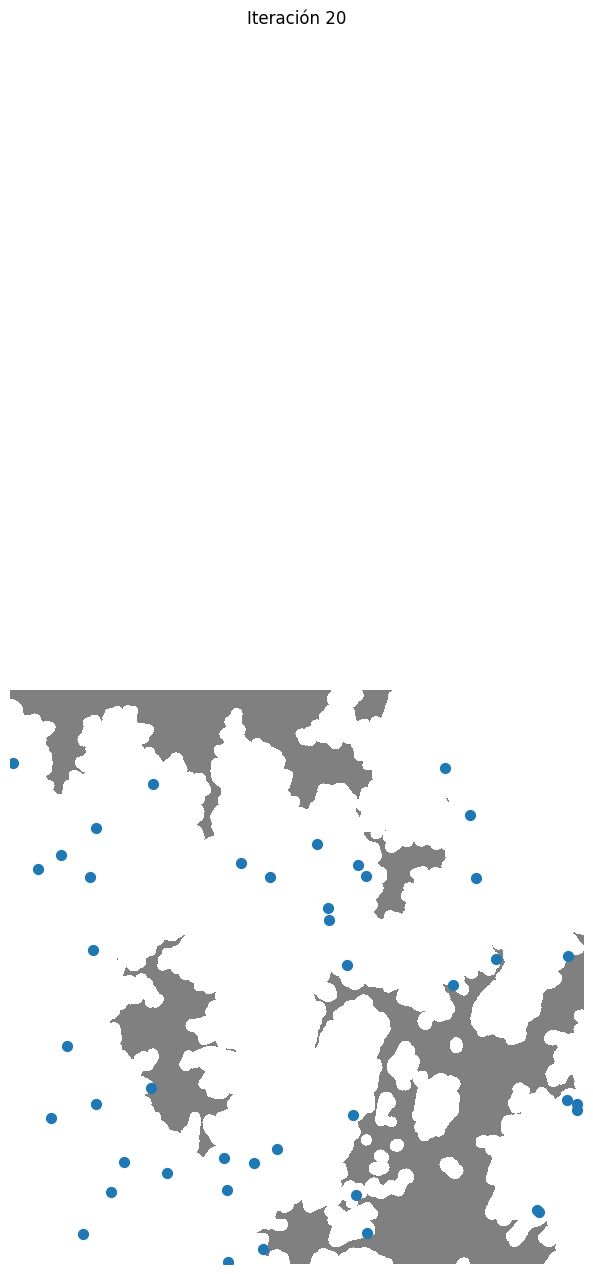

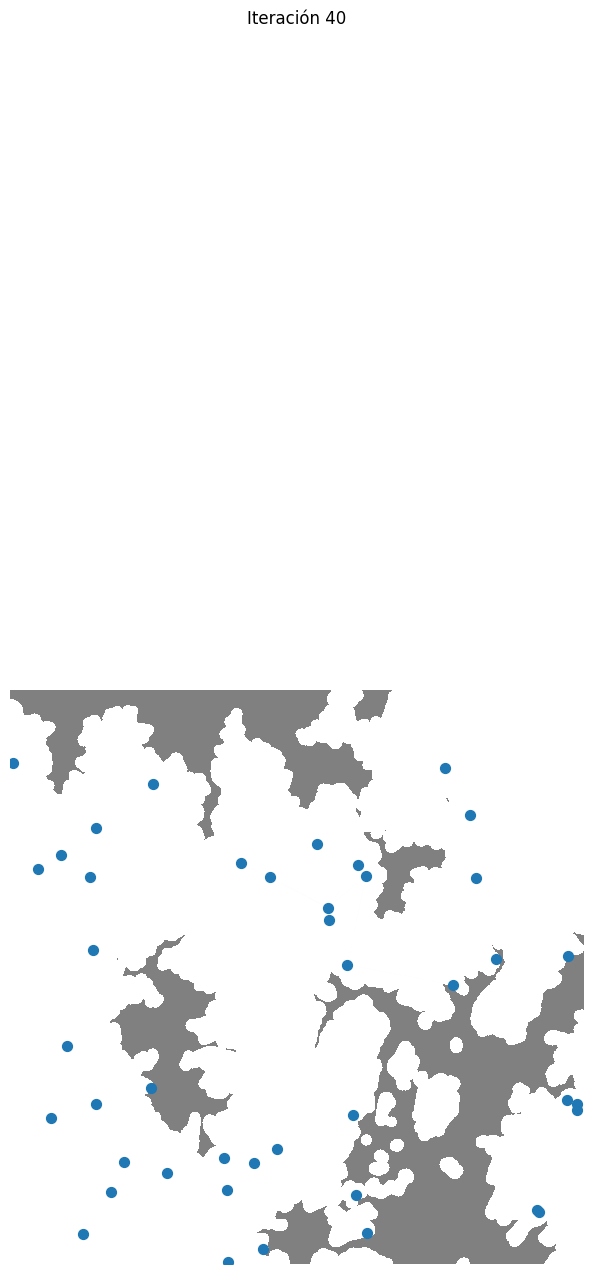

Iteración 50/500 completada.


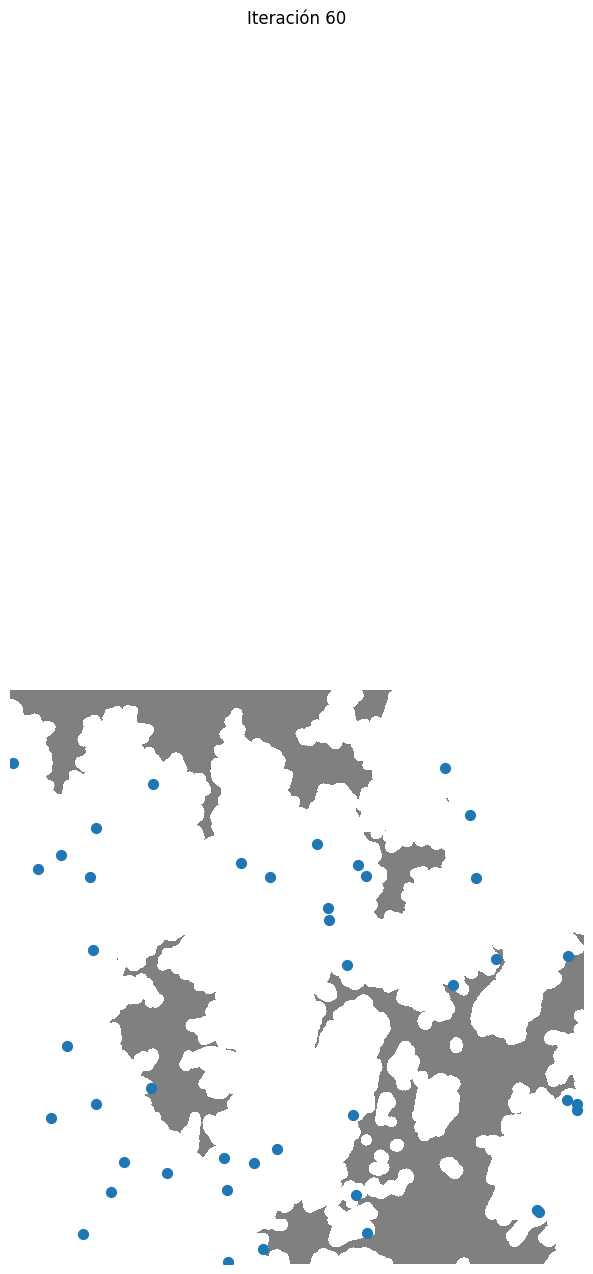

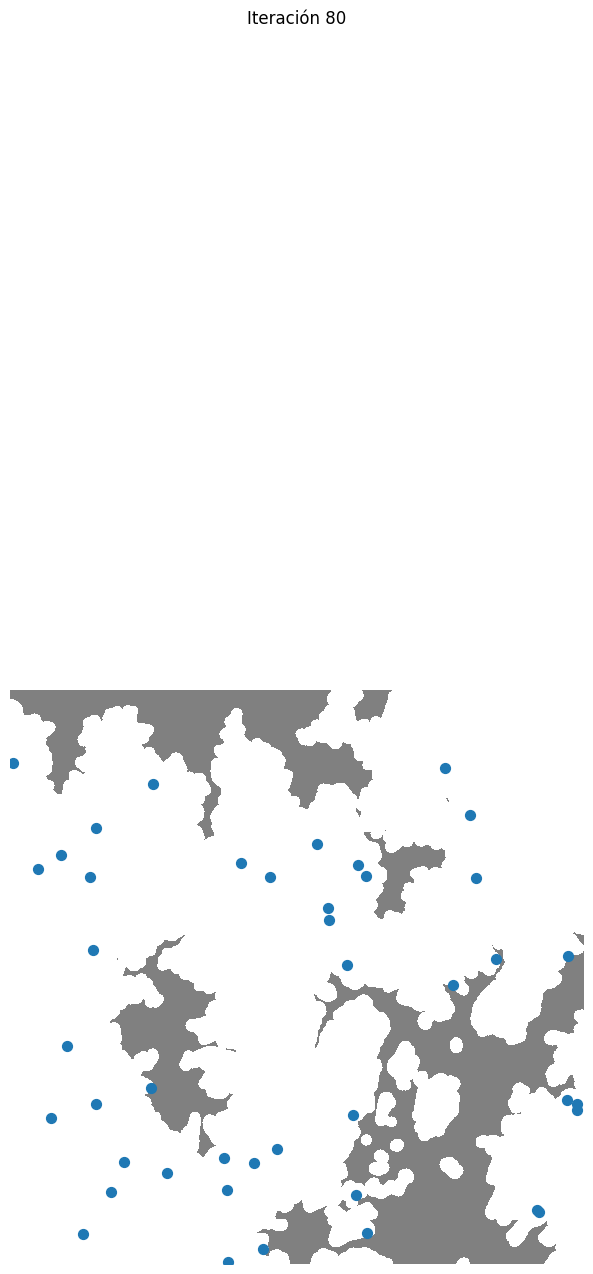

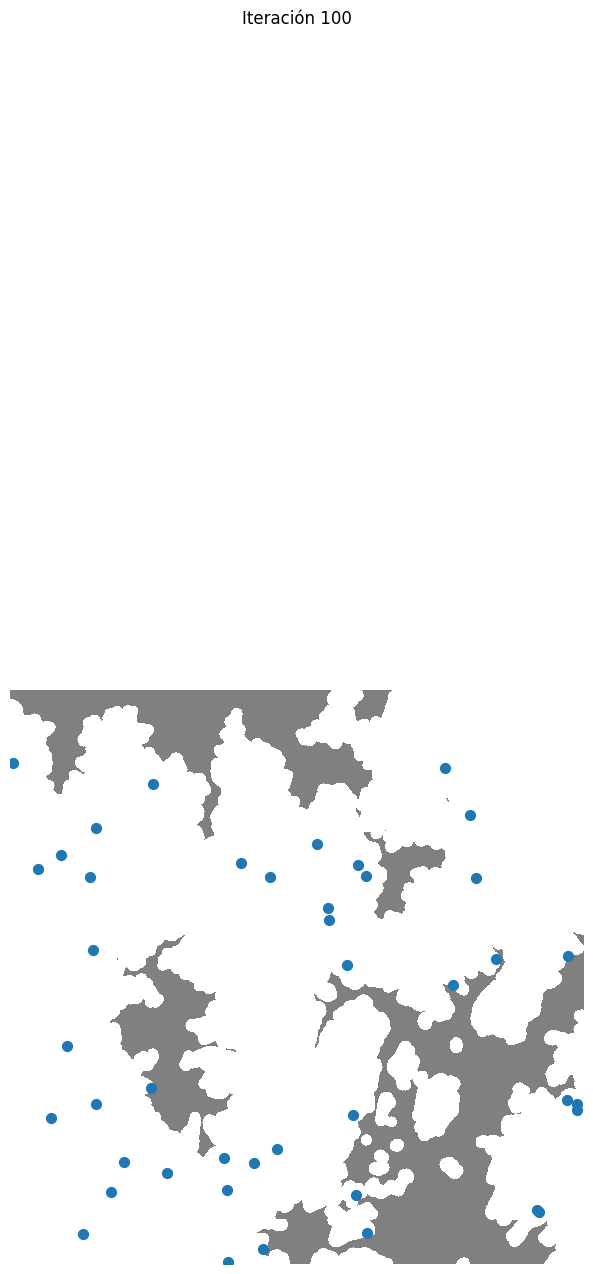

Iteración 100/500 completada.


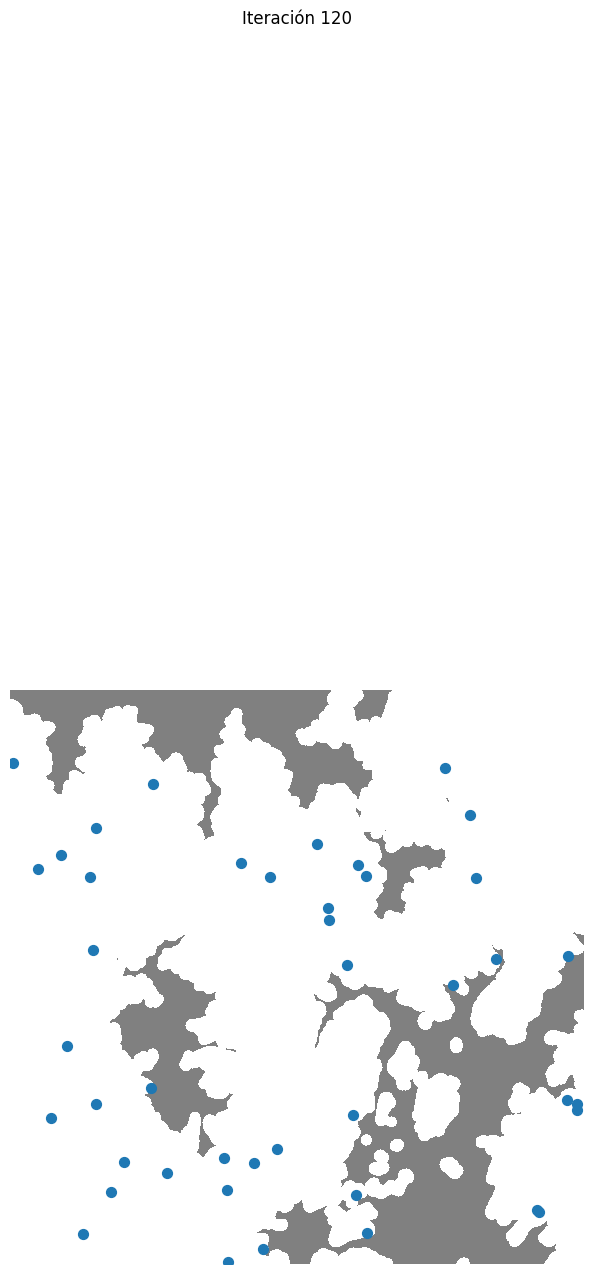

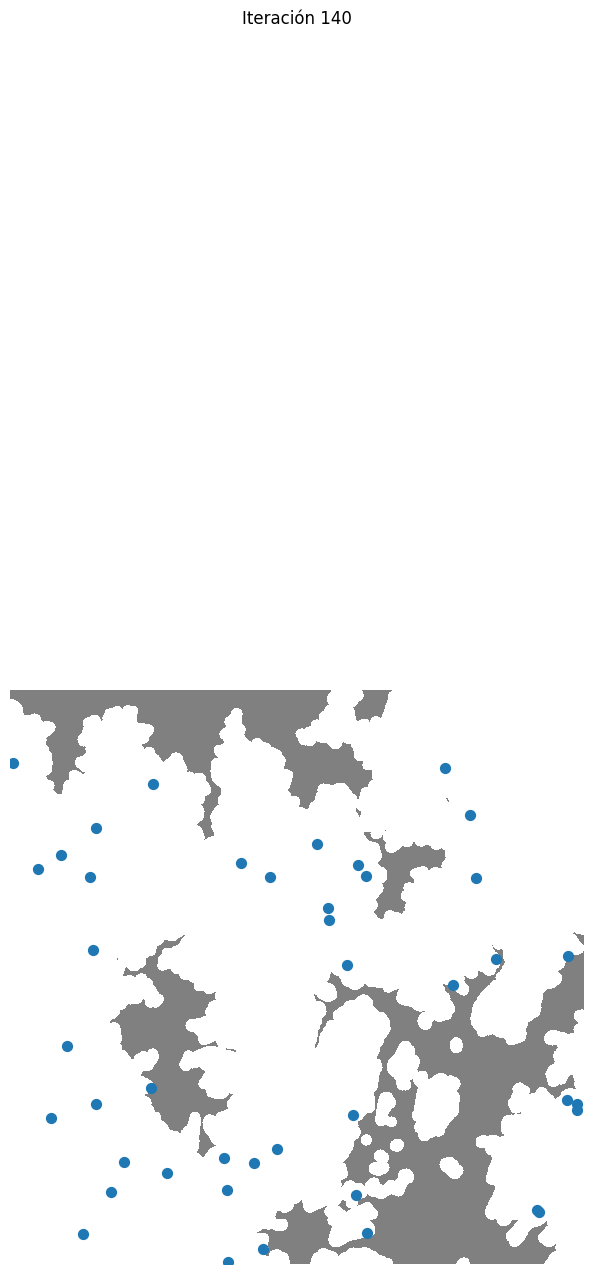

Iteración 150/500 completada.


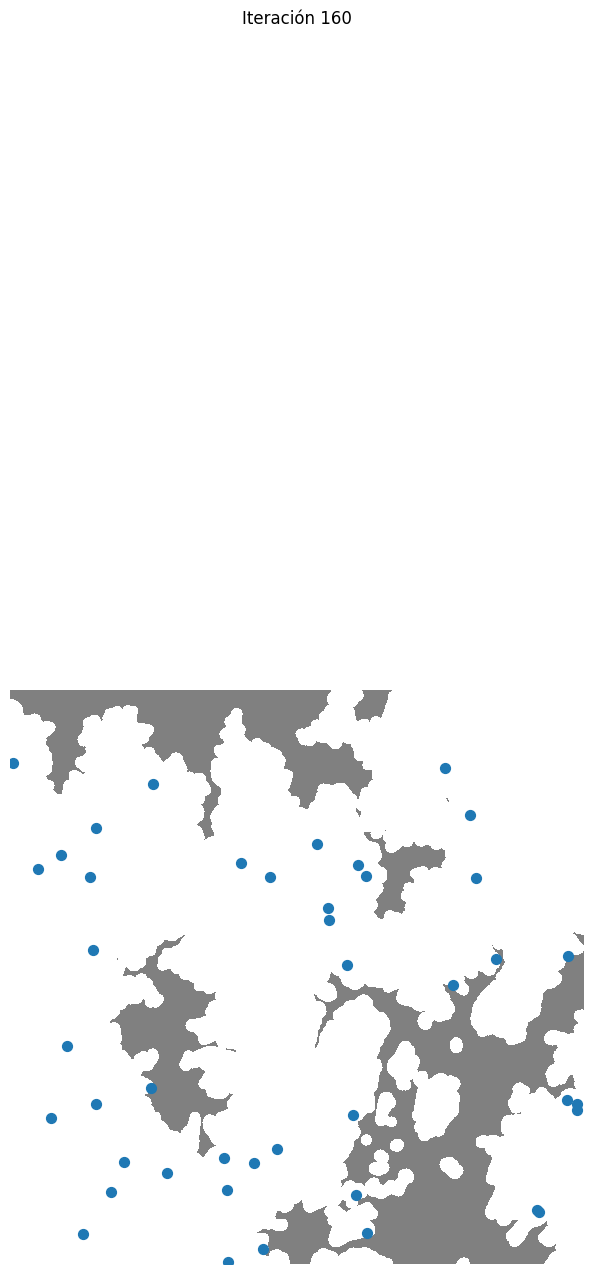

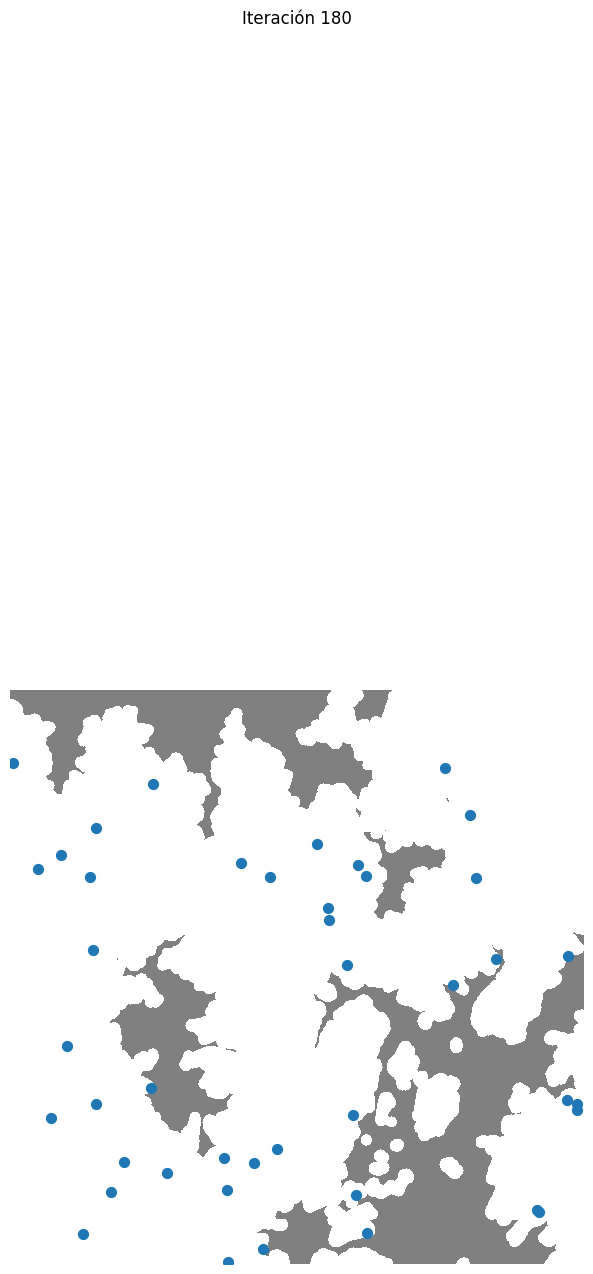

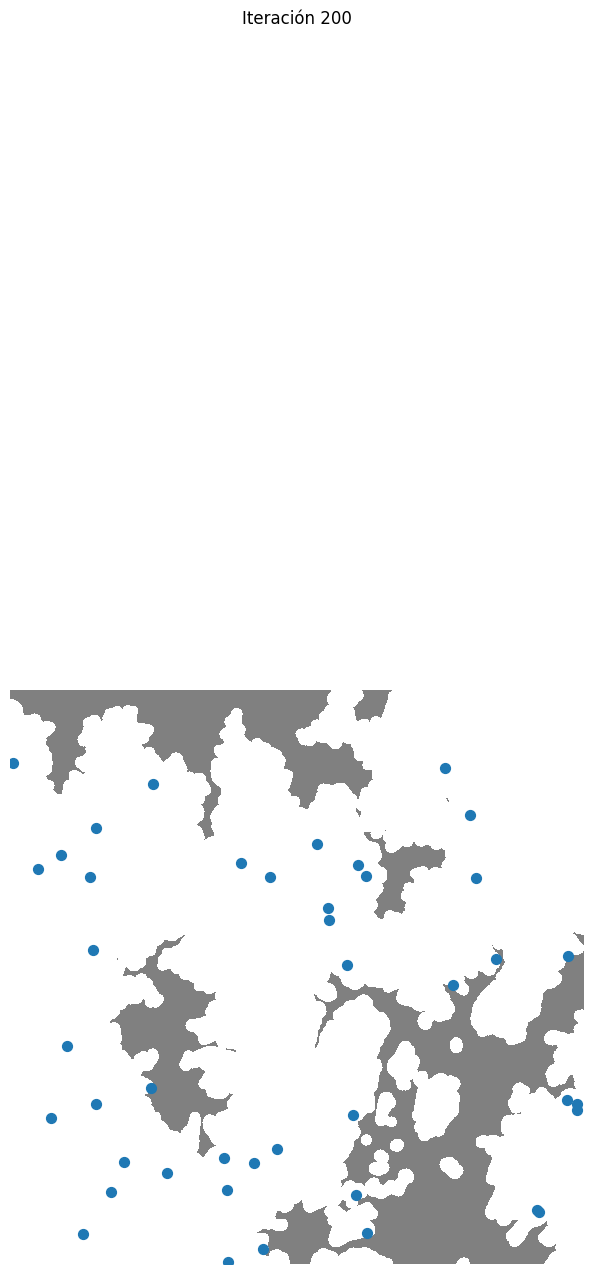

Iteración 200/500 completada.


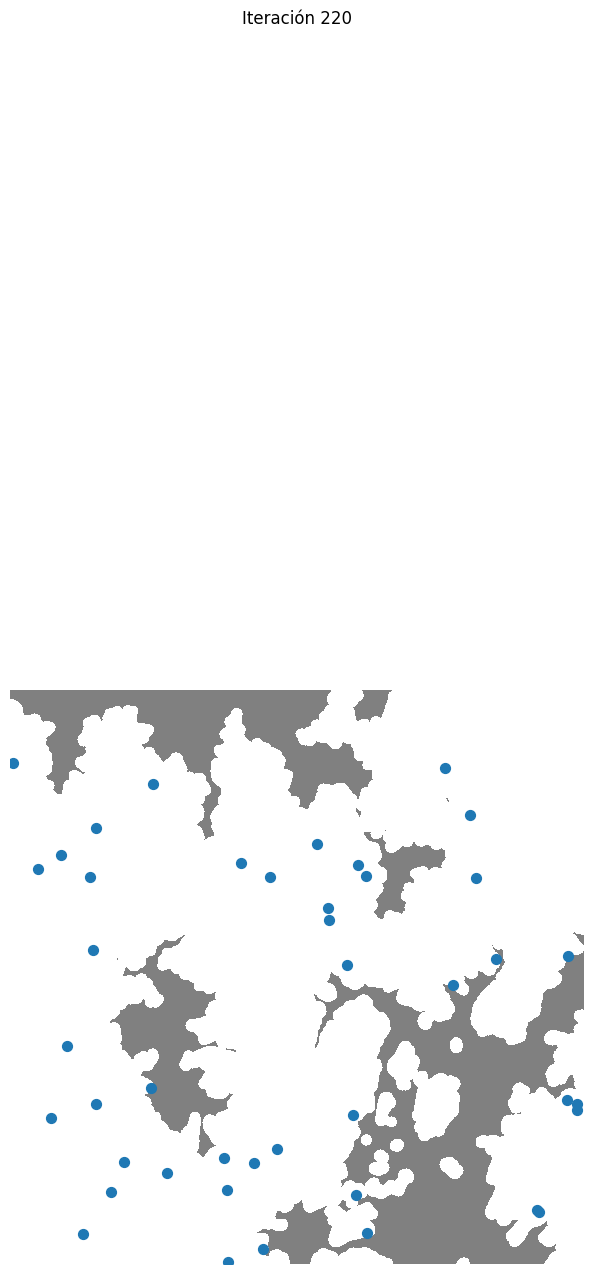

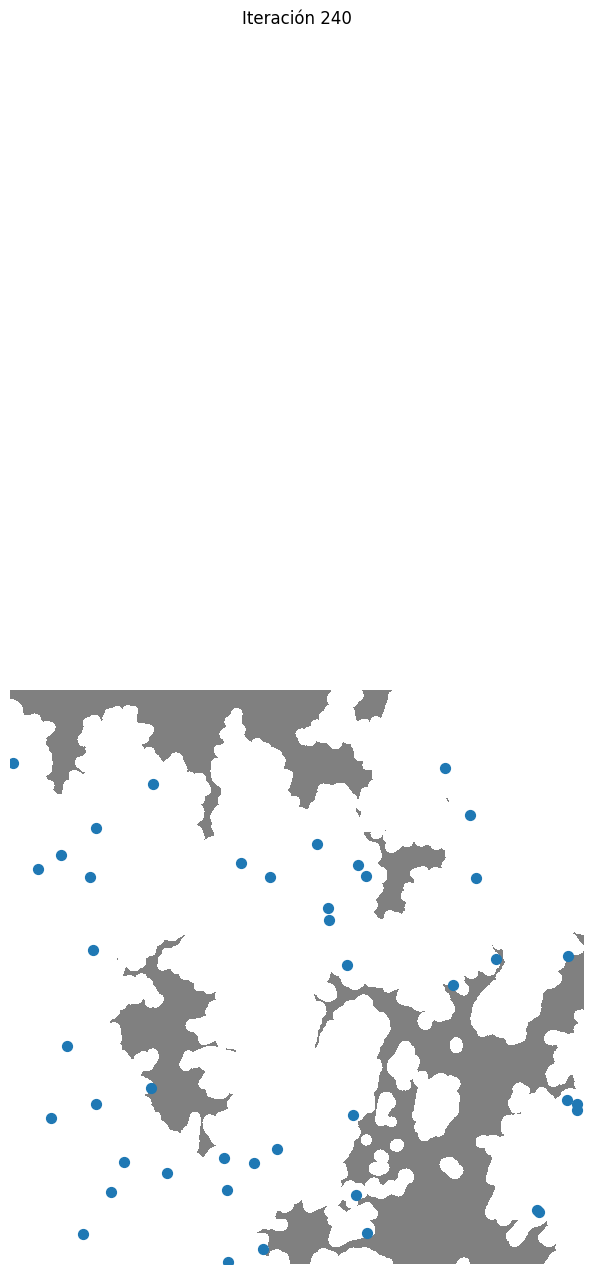

Iteración 250/500 completada.


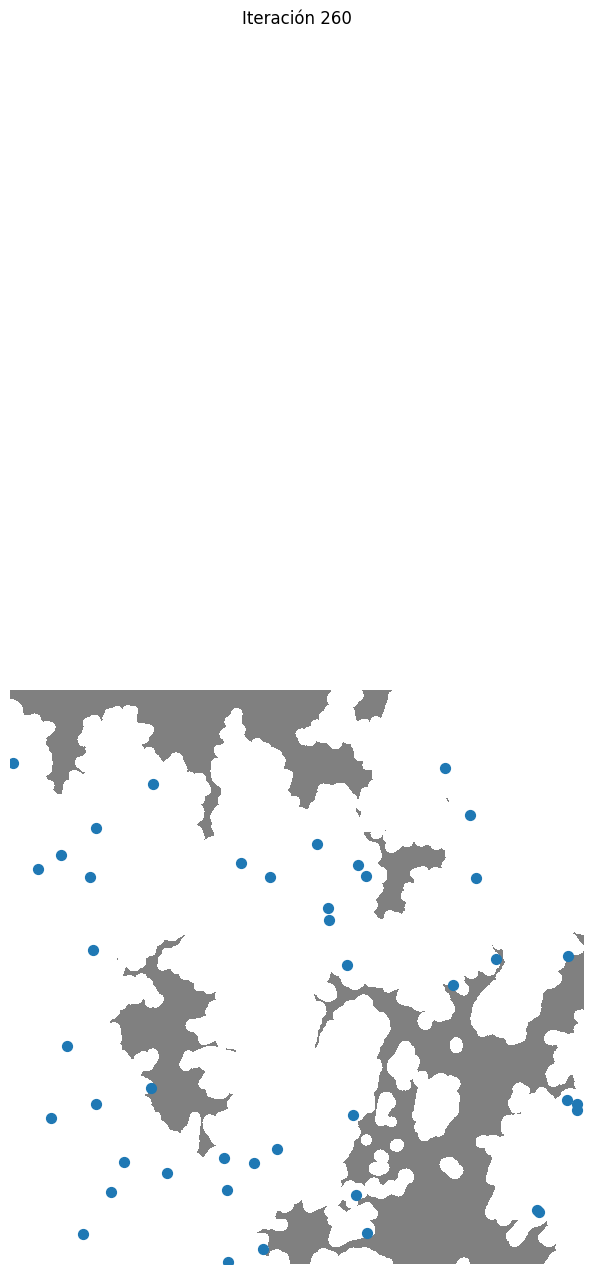

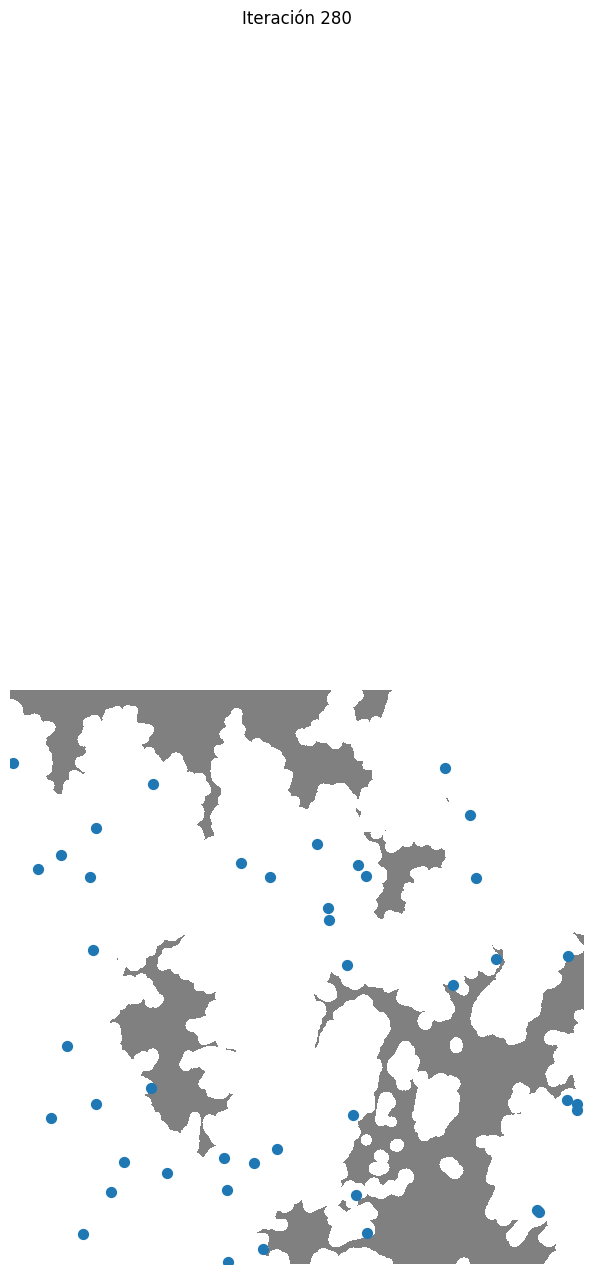

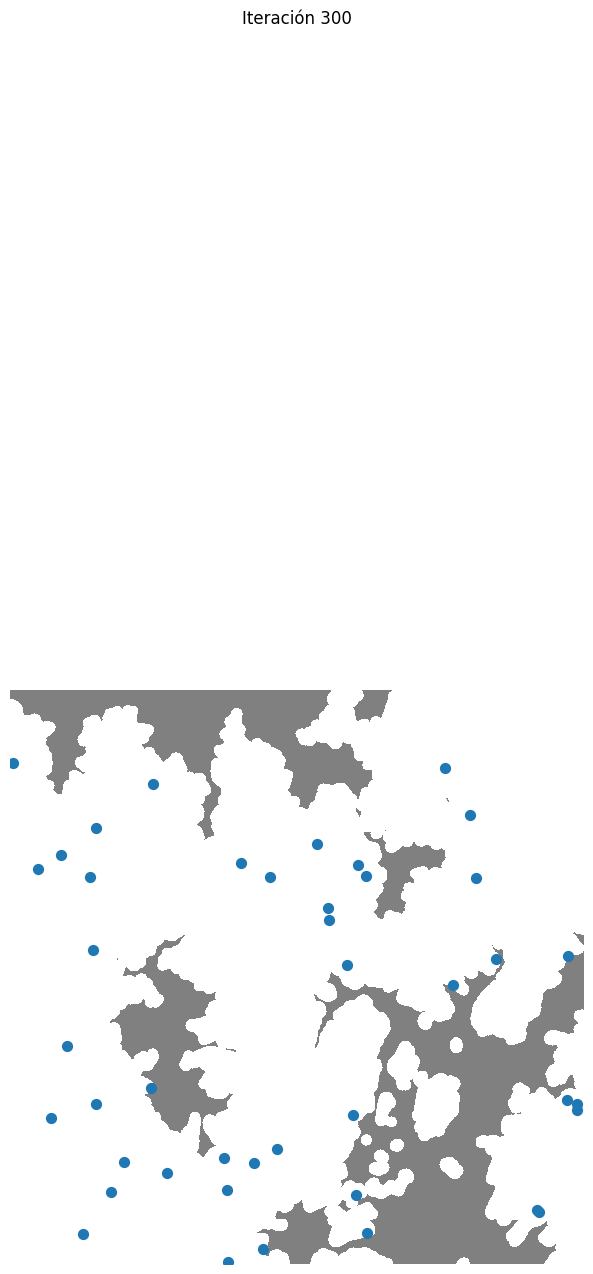

Iteración 300/500 completada.


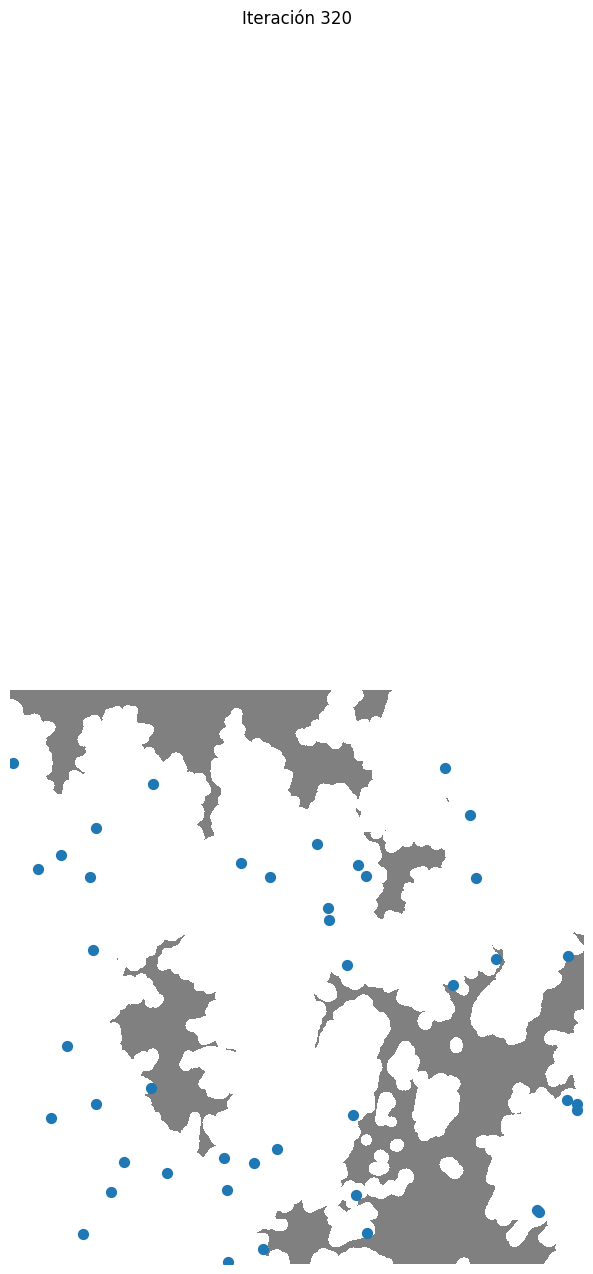

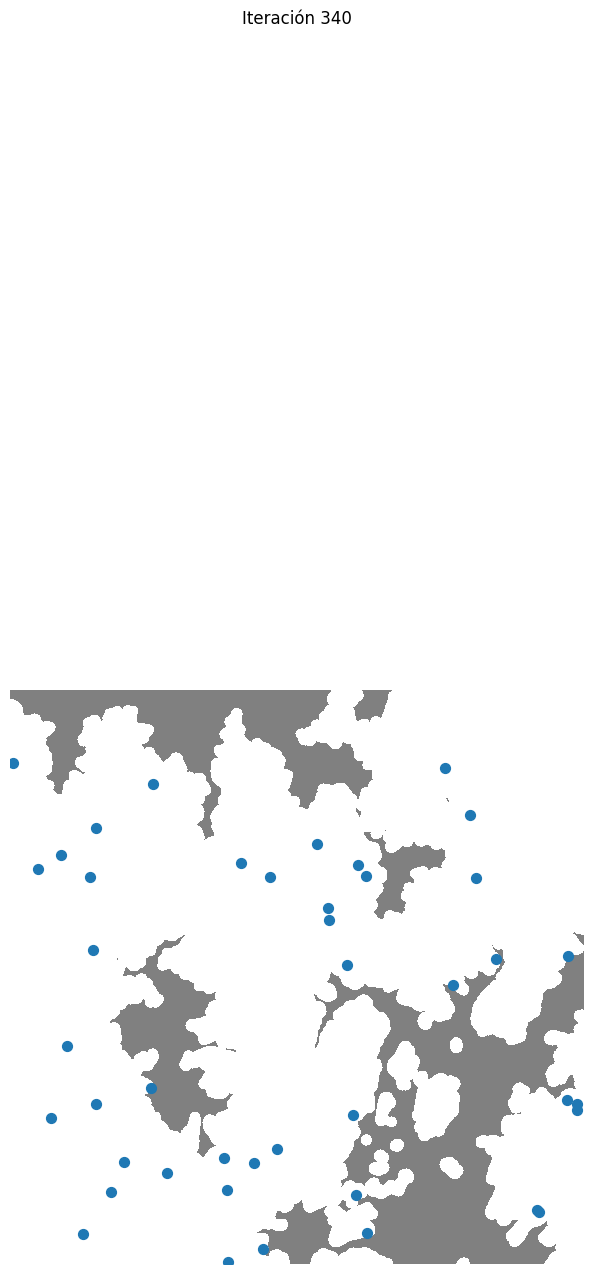

Iteración 350/500 completada.


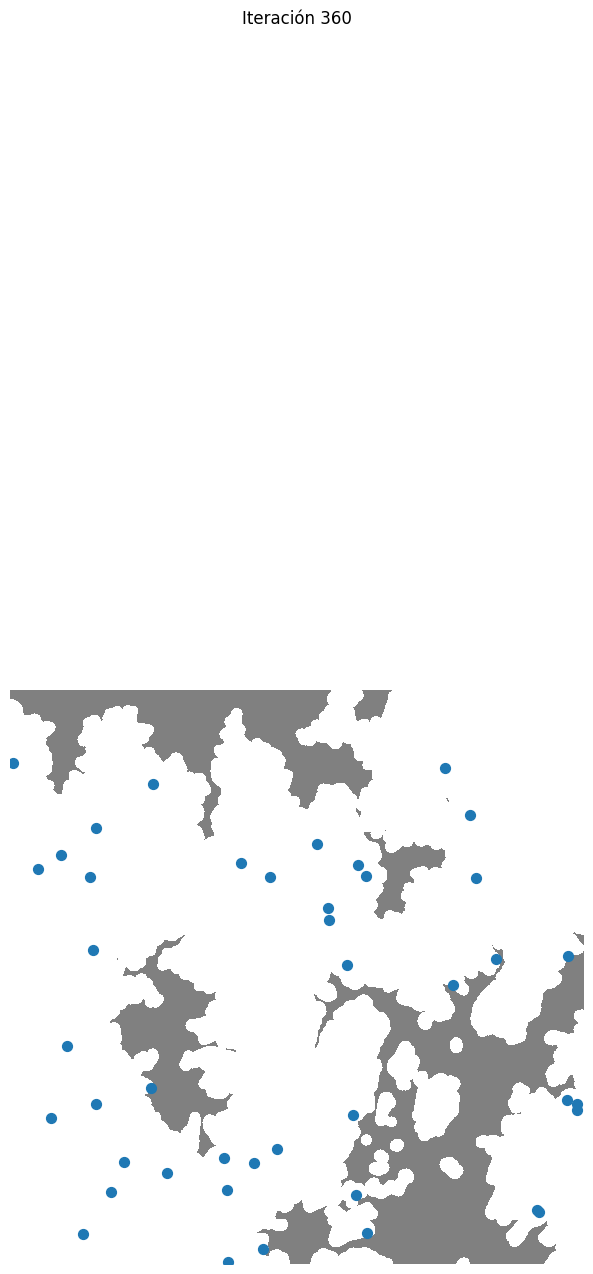

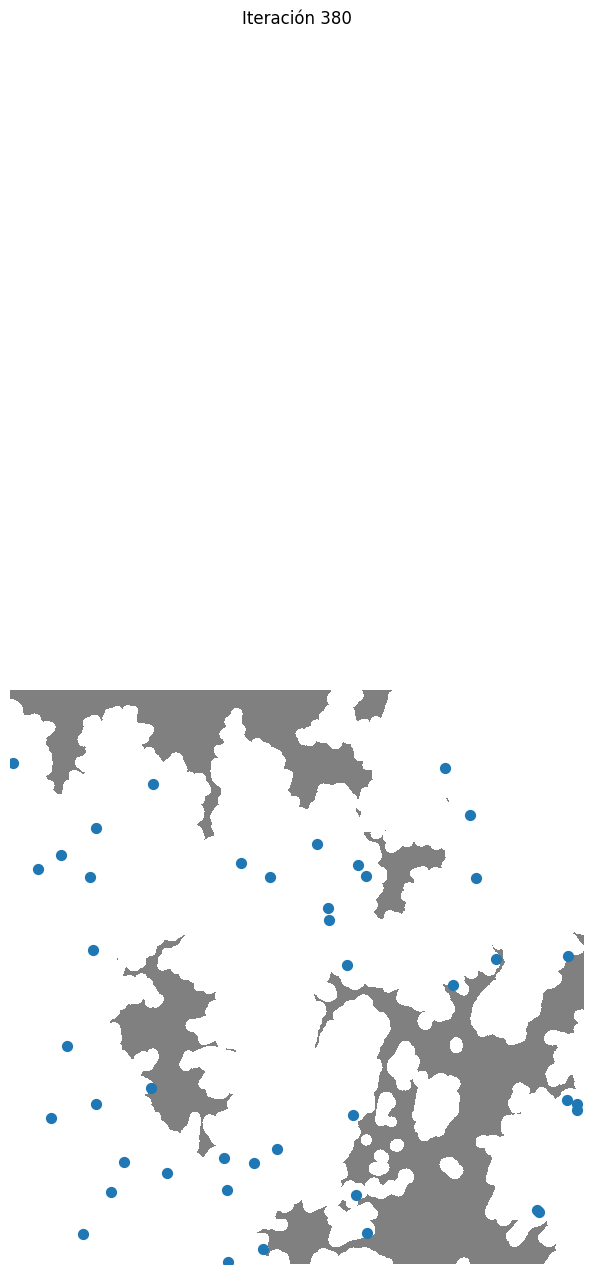

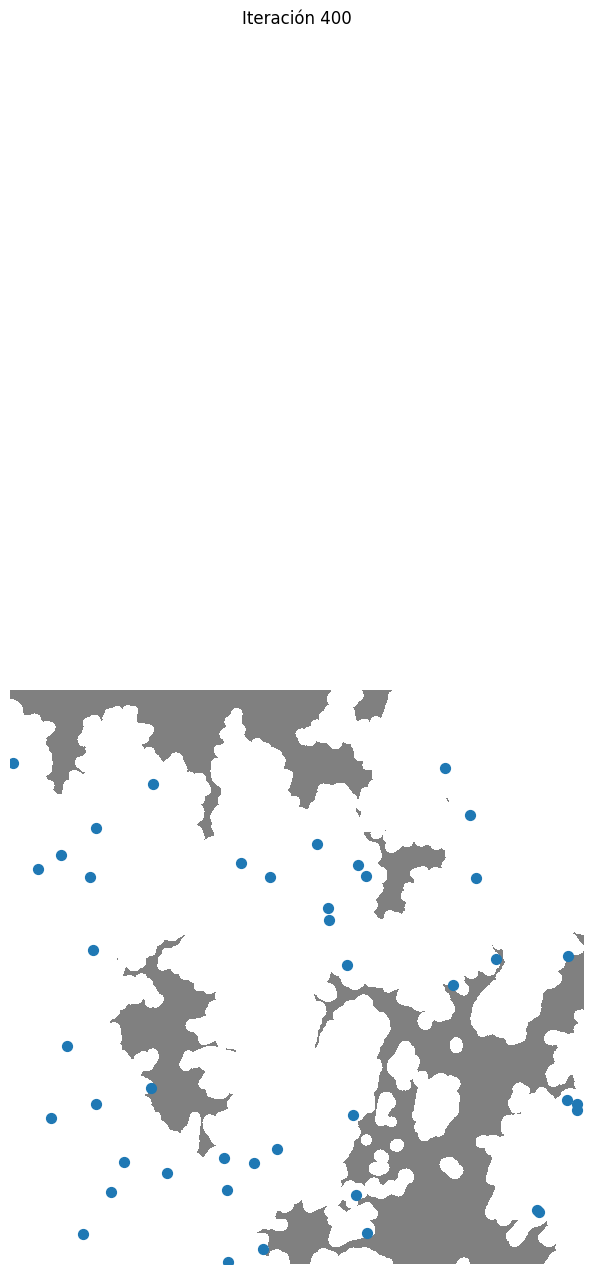

Iteración 400/500 completada.


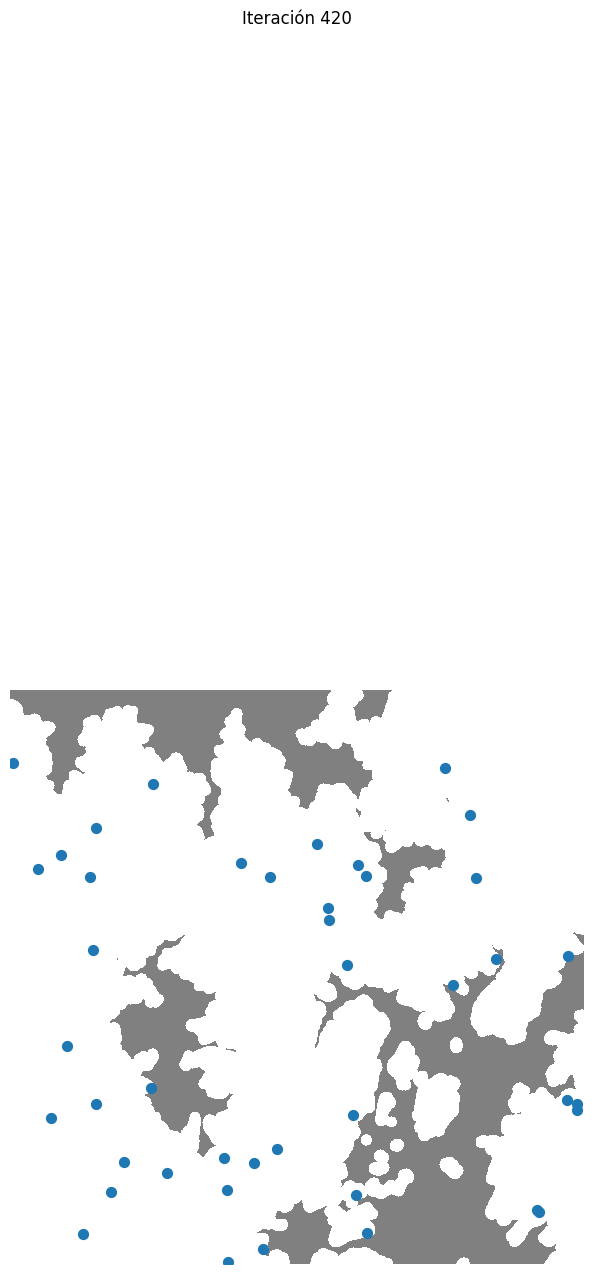

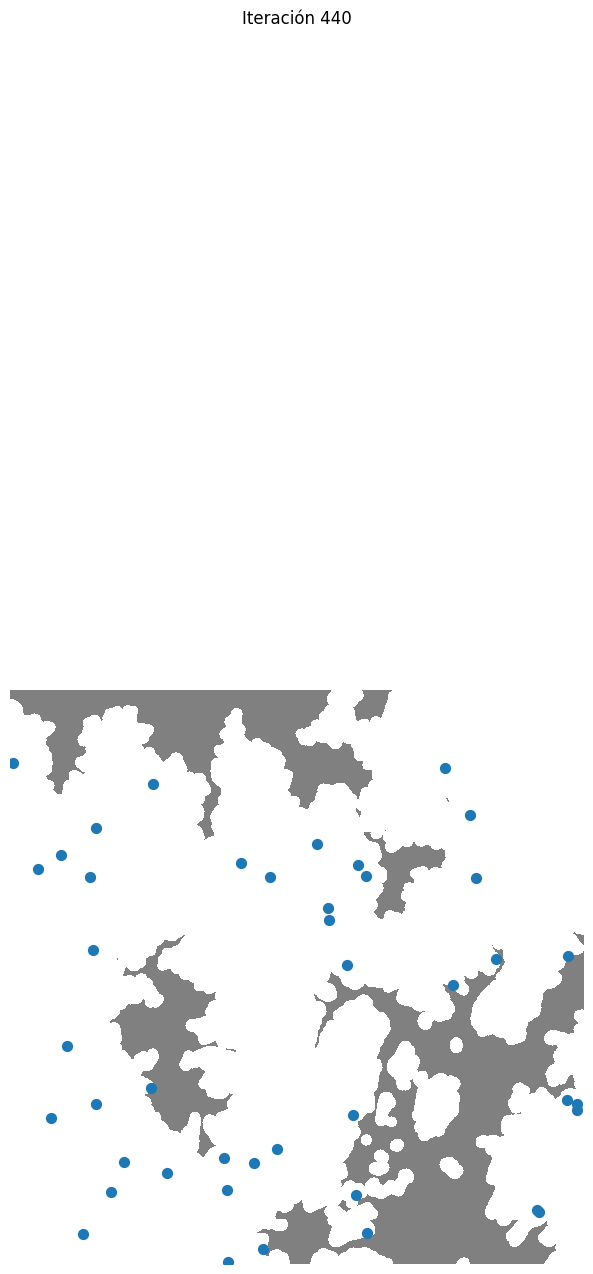

Iteración 450/500 completada.


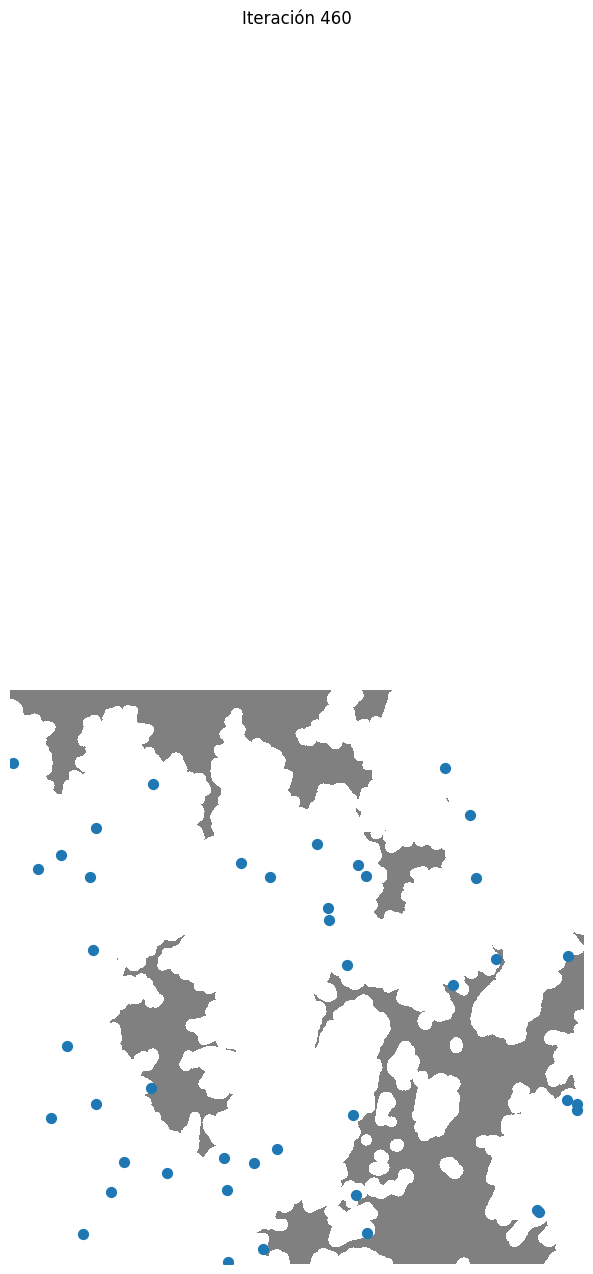

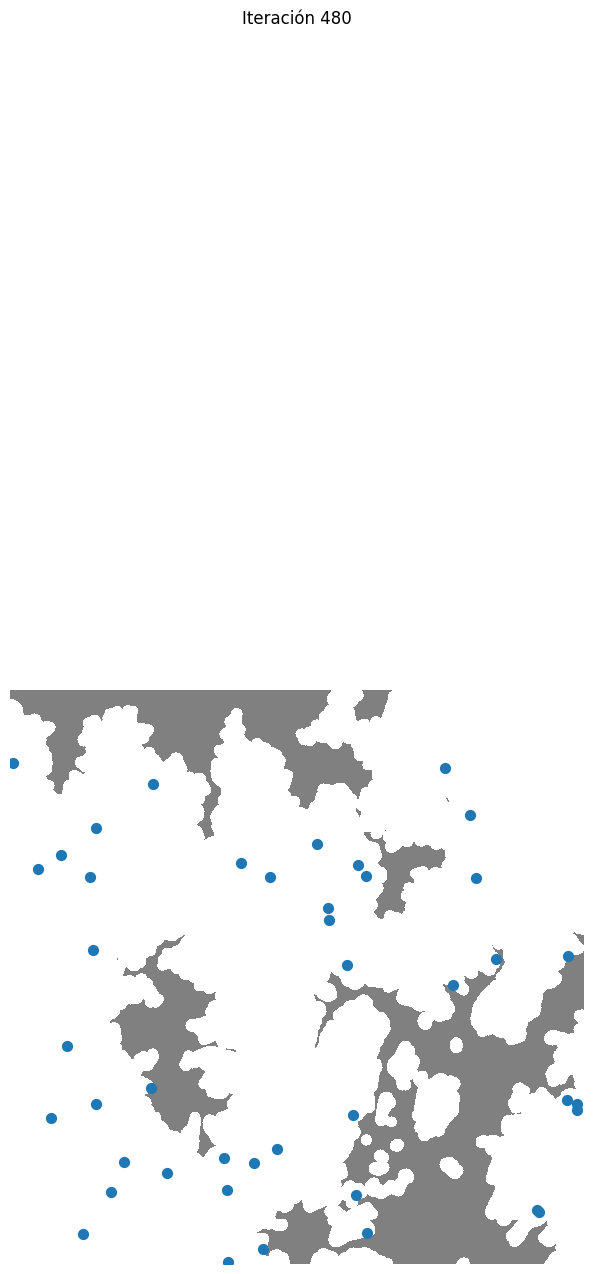

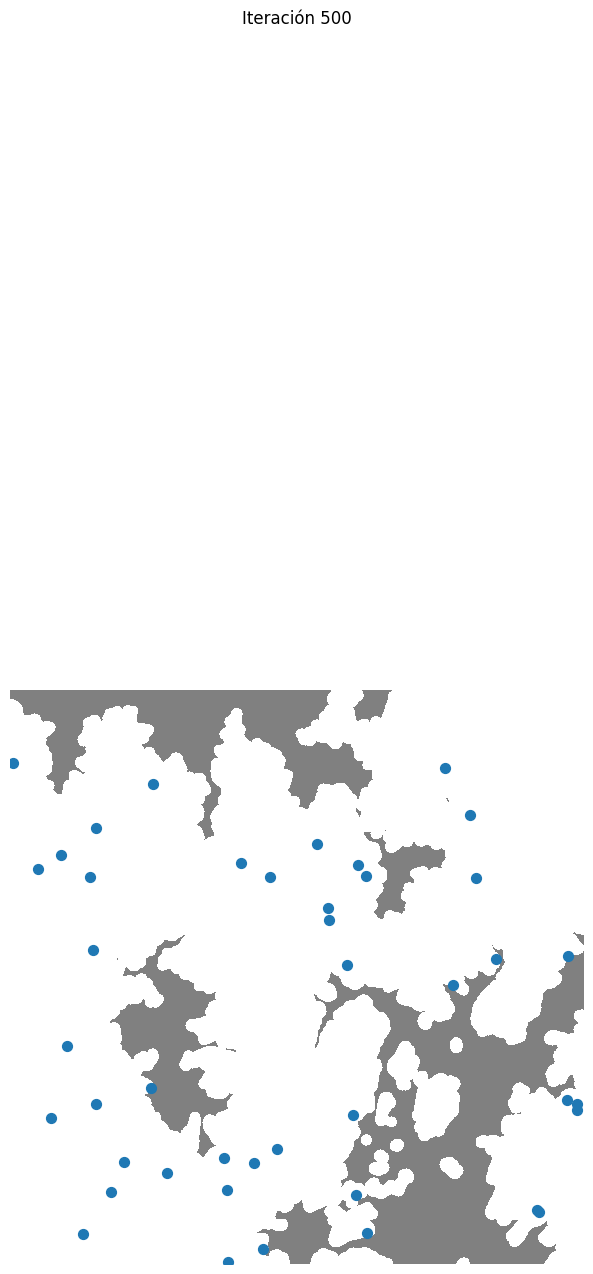

Iteración 500/500 completada.
Simulation completed.


In [98]:
# Model parameters - all these parameters can be played with during the experimentation to show how each of them impacts the resulting network.
I0 = 1.0                # Flux intesity
nl_factor = 2.0         # Non linearity factor
time_delta = 0.1        # Time delta
num_iterations = 500   # Number of iterations

# Lista para almacenar el historial de conductividades (opcional)
conductivity_history = []

# For the given number of iteartions
for iteration in range(num_iterations):
    # Randomly select the a siphon and a sink node.
    source_node = random.choice(list(G.nodes())) # Source/siphon node
    sink_node = random.choice(list(G.nodes())) # sinc node
    while sink_node == source_node:
        sink_node = random.choice(list(G.nodes()))

    if not(line_collision_points(boolean_map, source_node, sink_node)):
    # Ajustar las presiones y calcular los flujos
      p, Q = adjust_pressures(G, source_node, sink_node, I0)
    # Actualizar las conductividades
      update_conductivities(G, Q, time_delta, nl_factor)

    # Almacenar las conductividades para visualización (cada 10 iteraciones)
    if iteration % 10 == 0:
        D_values = [G.edges[edge]['conductivity'] for edge in G.edges()]
        conductivity_history.append(D_values)

    # Visualizar la red cada 20 iteraciones
    if (iteration + 1) % 20 == 0:
        plt.figure(figsize=(16, 16))
        edge_widths = [G.edges[edge]['conductivity'] * 5 for edge in G.edges()]
        pos = node_positions  # Usar las posiciones aleatorias de los nodos

        # Dibujar los obstáculos
        plt.imshow(boolean_map, cmap=cmap_elevation_mask)
        nx.draw(G, pos=inverse_node_positions, node_size=50, width=edge_widths, with_labels=False, edge_color='blue')
        plt.title(f'Iteración {iteration + 1}')
        plt.xlim(0, workspace_latitude)
        plt.ylim(0, workspace_longitude)
        plt.show()

    # Información de progreso (opcional)
    if (iteration + 1) % 50 == 0:
        print(f"Iteración {iteration + 1}/{num_iterations} completada.")

print("Simulation completed.")

In [92]:
num_nodos = 100
inverse_node_positions = {}
for node_id in range(num_nodos):
        x, y = node_positions[node_id]
        inverse_node_positions[node_id] = (y, x)


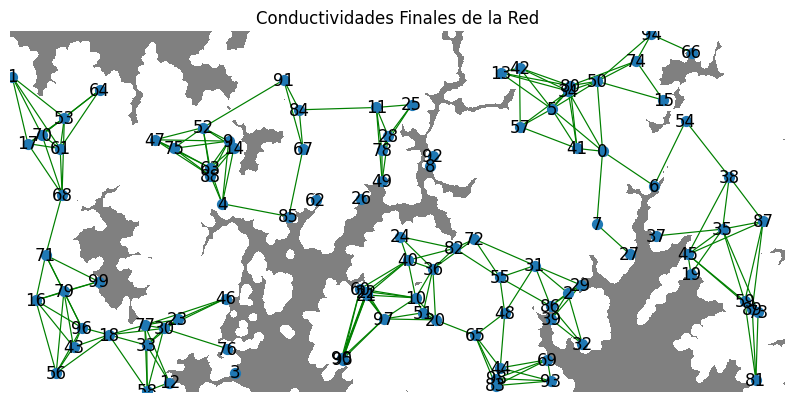

In [95]:
# Render final network
plt.figure(figsize=(10, 10))

# Set edge width based on edge conductivity.
edge_widths = [G.edges[edge]['conductivity'] * 50000 for edge in G.edges()]  # Factor by N for better visualization

# Render restricted areas
plt.imshow(boolean_map, cmap=cmap_elevation_mask)

# Render graph
nx.draw(G, pos=inverse_node_positions, node_size=50, width=edge_widths, with_labels=True, edge_color='green')

plt.title('Conductividades Finales de la Red')
plt.ylim(0, workspace_latitude)
plt.xlim(0, workspace_longitude)

plt.show()

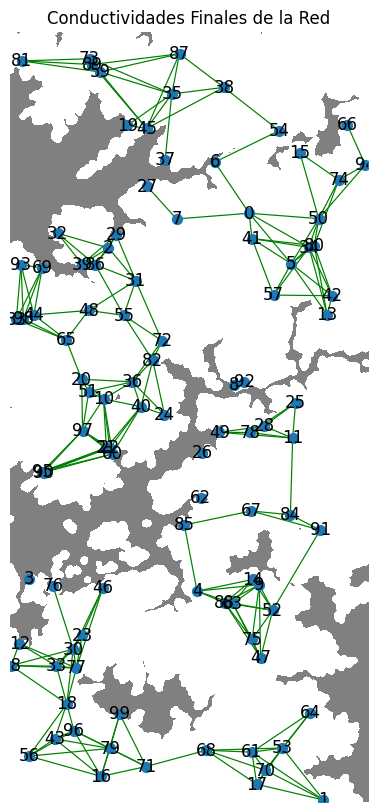

In [97]:
# Render final network
plt.figure(figsize=(10, 10))

# Set edge width based on edge conductivity.
edge_widths = [G.edges[edge]['conductivity'] * 50000 for edge in G.edges()]  # Factor by N for better visualization

# Render restricted areas
plt.imshow(boolean_map.T, cmap=cmap_elevation_mask)

# Render graph
nx.draw(G, pos=node_positions, node_size=50, width=edge_widths, with_labels=True, edge_color='green')

plt.title('Conductividades Finales de la Red')
plt.xlim(0, workspace_latitude)
plt.ylim(0, workspace_longitude)

plt.show()

KeyboardInterrupt: 

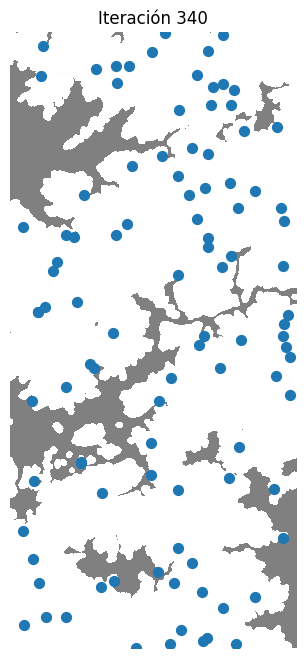

In [64]:
# Figure for animated series / this can only genereated if we tracked the condictuvity history
fig, ax = plt.subplots(figsize=(8, 8))

def animate(i):
    ax.clear()
    edge_widths = [conductivity_history[i][idx] * 5 for idx in range(len(G.edges()))]
    current_edges = list(G.edges())

    # Render map with restricted areas
    plt.imshow(boolean_map.T, cmap=cmap_elevation_mask)

    nx.draw(G, pos=node_positions, ax=ax, node_size=50, width=edge_widths, with_labels=False, edge_color='blue')

    ax.set_title(f'Iteración {i * 10}')
    plt.xlim(0, workspace_latitude)
    plt.ylim(0, workspace_longitude)
    ax.axis('off')

# Create aniamtion - each frame represents progress every 10 iterations - like it was saved in the calcualting method
ani = animation.FuncAnimation(fig, animate, frames=len(conductivity_history), interval=500, repeat=False)

# Load animation in notebook
HTML(ani.to_jshtml())

## <font color='darkblue'> Discarded: Using GPS values for nodes </font>
Another POC that was discarded due to possible complexity and time constraints was the use of nodes with real GPS locations. Included adjusted methods for reference:

In [ ]:
#Plane Geo Boundaries
min_lon, max_lon = -100.50, -100.00
min_lat, max_lat = 25.580, 25.9550
initial_location = [25.70, -100.30]
zoom_start_defined = 12

In [ ]:
import folium

m = folium.Map(
    location= initial_location,
    width= '40%',
    height= '40%',
    max_bounds=True,
    zoom_start=zoom_start_defined,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    min_zoom= 12,
    max_zoom=18
)

In [ ]:
coordinates = [
    [ 25.610   ,  -100.30    ],
    [  25.757,  -100.2780]]
my_PolyLine=folium.PolyLine(locations=coordinates,weight=5)
m.add_child(my_PolyLine)

In [ ]:
#Use this method to generate random nodes with GPS coordiantes that fall within our desired plane
def generate_nodes(node_qty, min_lat, max_lat, min_lon, max_lon):
    node_coordinates = {}
    for node_instance in range(node_qty):
        x, y = np.random.uniform(min_lat, max_lat), np.random.uniform(min_lon, max_lon)
        node_coordinates[node_instance] =((x, y))
        # may need to do some validaiton around points - TBD
    return node_coordinates # return coordinates when done

In [ ]:
#lets generate 30 test coordinates
coord = generate_nodes(30, min_lat, max_lat, min_lon, max_lon)
coord

{0: (25.626664504484562, -100.31135375398745),
 1: (25.585511515600377, -100.33332636404224),
 2: (25.829231226635713, -100.46186085751262),
 3: (25.698558872832052, -100.3442991773161),
 4: (25.85313047657948, -100.26102029170266),
 5: (25.788632831155454, -100.45195963573926),
 6: (25.945364337047412, -100.1119680994972),
 7: (25.736282338413808, -100.31417027444324),
 8: (25.886612927104057, -100.38533201003585),
 9: (25.954520675556996, -100.24100422190193),
 10: (25.82394266511575, -100.35771503984436),
 11: (25.76123481865322, -100.41894115543116),
 12: (25.69232527127989, -100.04648353965037),
 13: (25.63550566589332, -100.44868868536594),
 14: (25.688045857290653, -100.26465712214532),
 15: (25.690561755243234, -100.05077766928258),
 16: (25.599766022738535, -100.42591754019107),
 17: (25.83703155140347, -100.02655697259966),
 18: (25.865733181950365, -100.21028277355273),
 19: (25.624556354971258, -100.18215669402738),
 20: (25.898799795263493, -100.3297133430653),
 21: (25.91

In [ ]:
# Use this method to add markers to folium map - marker style can be changed, refer to folium documentation
def set_map_markers(coordinates):
  for key in coordinates:
    pair = coordinates[key]
    folium.Marker(location=[pair[0],pair[1]]).add_to(m)

set_map_markers(coord) # add markers to the map

m #render map with markers

In [ ]:
#method used to generate a graph based on a list of coordiantes

def generate_graph(coordinates):
    # Define and empty graph.
    graph = nx.Graph()
    # Add the defined nodes to the graph.
    graph.add_nodes_from(coordinates)
    return graph

GC = generate_graph(coord)

In [ ]:
import geopy.distance
#This method will generate edges between every node and K closest neighbours

def connect_nodes(graph, k, coordinates):
  for pivot_marker in graph.nodes(): # for each node in our graph
    distances = [] # define distances lists
    for second_marker in graph.nodes(): # get a second marker from our graph
        if second_marker != pivot_marker: #if we are not referring to the same marker
            #print(geopy.distance.geodesic(first_marker, second_marker).km)
            dist = geopy.distance.geodesic(coordinates[pivot_marker], coordinates[second_marker]).km # calculate distance between nodes
            distances.append((second_marker, dist)) #set distance from the pivot marker to the iterator marker, distance is saved in km

    # Order by distance magnitde and select the k closest nodes.
    distances.sort(key=lambda x: x[1])
    adjacent_neighbours = [n for n, d in distances[:k]]

    for neighbour in adjacent_neighbours:
      # Create a line between connected nodes.
      if not graph.has_edge(pivot_marker, neighbour):
        graph.add_edge(pivot_marker, neighbour)

In [ ]:
connect_nodes(GC, 4,coord)

In [ ]:
def initialize_conductivity_longitude(graph,coordinates):
# Initialize conductivity and longitude for each graph edge.
  D = {}
  L = {}
  for edge in graph.edges():
    # Initial conductivity as 1
    D[edge] = 1.0
    # Calculate longitude for the edge
    pos_i = edge[0]
    pos_j = edge[1]
    length = geopy.distance.geodesic(coordinates[pos_i],coordinates[pos_j]).km # calculate distance between nodes
    L[edge] = length # save the longitude

  # Set edge conductivity and longitude
  nx.set_edge_attributes(graph, D, 'conductivity')
  nx.set_edge_attributes(graph, L, 'length')

In [ ]:
initialize_conductivity_longitude(GC,coord)

In [ ]:
def adjust_pressures_GEO(graph, siphon_node, sink_node, I0, debug):
    # QTY of nodes
    num_nodes = graph.number_of_nodes()
    node_list = list(graph.nodes())
    node_indexes = {node: idx for idx, node in enumerate(node_list)}

    # Siphon and sinks vector
    S = np.zeros(num_nodes) # init to zeros
    S[node_indexes[siphon_node]] = I0 # set IO for our siphone node
    S[node_indexes[sink_node]] = -I0  # set -IO for sink node

    # Conductances Matrix - intialized as zeros matrix
    C = np.zeros((num_nodes, num_nodes))

    for edge in graph.edges():
        if(debug):
          print(f"edge {edge}")
        i = node_indexes[edge[0]]
        j = node_indexes[edge[1]]
        D_ij = graph.edges[edge]['conductivity']
        L_ij = graph.edges[edge]['length']
        if(debug):
            print(f"Edge Conductivity: {D_ij}")
            print(f"Edge Length: {L_ij}")
        C_ij = D_ij / L_ij
        C[i, j] = -C_ij
        C[j, i] = -C_ij
        C[i, i] += C_ij
        C[j, j] += C_ij

    # Condición de frontera (Set sink node pressure to zero)
    sink_idx = node_indexes[sink_node] #index of our sink node
    C_reduced = np.delete(np.delete(C, sink_idx, axis=0), sink_idx, axis=1)
    S_reduced = np.delete(S, sink_idx)

    # Solve the pressure linear system
    try:
        p_reduced = np.linalg.solve(C_reduced, S_reduced)
    except np.linalg.LinAlgError:
        # If matrix is not invertible, set pressures as zero
        p_reduced = np.zeros(num_nodes - 1)

    # Insertar pressure in the sink node
    p = np.insert(p_reduced, sink_idx, 0)

    # Calculate flux in each edge
    Q = {}
    for edge in graph.edges():
        i = node_indexes[edge[0]]
        j = node_indexes[edge[1]]
        D_ij = graph.edges[edge]['conductivity']
        L_ij = graph.edges[edge]['length']
        Q_ij = D_ij * (p[i] - p[j]) / L_ij
        Q[edge] = Q_ij
    #return pressure and edge-flux
    return p, Q

In [ ]:
def update_conductivities_GEO(graph, Q, time_delta, nl_factor):

    edges_to_remove = []
    for edge in graph.edges():
          D_ij = graph.edges[edge]['conductivity']
          Q_ij = abs(Q[edge])
          # Sigmoind function
          f_Q = (Q_ij ** graph) / (1.0 + Q_ij ** graph)
          dD_dt = f_Q - D_ij
          D_new = D_ij + time_delta * dD_dt
          # Conductivity must be positive. Avoid cero or negative conductivity.
          graph.edges[edge]['conductivity'] = max(D_new, 1e-6)
    # Remove invalid/interesecting edges.
    graph.remove_edges_from(edges_to_remove)

In [ ]:
# Model parameters
I0 = 1.0                # Flux intesity
nl_factor = 2.0         # Non linearity factor
time_delta = 0.1        # Time delta
num_iterations = 1000   # Number of iterations

def mold_geo_model(graph, num_iterations, flux, time_delta, nl_factor, debug):
  # Lista para almacenar el historial de conductividades (opcional
  conductivity_history = []

  # For the given number of iteartions
  for iteration in range(num_iterations):
      # Randomly select the a siphon and a sink node.
      source_node = random.choice(list(graph.nodes())) # Source/siphon node
      sink_node = random.choice(list(graph.nodes())) # sink node
      while sink_node == source_node:
          sink_node = random.choice(list(graph.nodes()))

      if(debug):
        print(f"Choosen siphon: {source_node}")
        print(f"Choosen sink: {sink_node}")

      # Adjust pressures between nodes.
      p, Q = adjust_pressures_GEO(graph, source_node, sink_node, flux, debug)

      # Update conductivities
      update_conductivities_GEO(graph, Q, time_delta, nl_factor)

      # Save conductivity for visualization (saving it every 10 iterations)
      if iteration % 100 == 0:
          D_values = [graph.edges[edge]['conductivity'] for edge in graph.edges()]
          conductivity_history.append(D_values)

      # Log iterations progress
      if (iteration + 1) % 50 == 0:
          print(f"Iteration {iteration + 1}/{num_iterations} completed.")

  print("Simulation completed.")